In [32]:
#Remarks
#check coefficients against equations
#be careful of copying and reassign values in numpy array
#export frequencies
#add pot_inf,ex_inf,ey_inf,ez_inf variables and assign s appropriately
#test case case=0 to test set_subdomains
#consider remove set_subdomain and change nnode to nnode_active
#specify as elements[in_active_zones,:] instead of elements[in_active_zones] and etc. except that dimension may vary by cases (e.g. cx/cy/cz)
#consider renaming in 'for irow in np.asmatrix(rows).T:' (done)
#let cx/cy/cz etc values on curved surface not 3d space in set_materials3d for case=3 (done)
#set_first_kind_bc3d may need to be updated for K.shape as (nnode*4,nnode*4) (changed ways to do this)
#add function zero_inactive_nodes (done)
#modify set_first_kind_bc to accomendate more rows in K
#take care of sigma_solid and gs signs by including direction of normal surface vector
#check Young–Laplace equation solution and use it to benchmark curved surface
#continue from Test 4 use numerical solution as input for unod1 (which is previous implementaion in set_materials2d) (problem is that mesh is too coarse on sphere)
#change u/unod to size of (*,4)

#Naming conventions
#unod3d is only used since unod2d does not exist due to indexing system; always a 1d vector
#u2d,u3d represent short version of uele_2d and uele_3d; each have four columns (first as field; rest as gradient vector)

#Test Case
# define materials using functions in each test case

#Unsolved
#distance scaling factor does not work for coupled problem

In [98]:
# mesh=import_mesh('sphere_s61.hdf5')
# nodes=mesh['nodes']
# faces=mesh['faces']
nodes=[[0,0,0], [1,0,0], [0,0,1], [0,1,1],
       [1,0,1], [0,1,0], [1,1,1], [1,1,0]]
nodes=np.array(nodes)
faces=[[0,2,4], [0,1,4], [2,3,4], [3,4,5], [3,5,6], [0,1,7]]
faces=np.array(faces)

nface=len(faces)
u=np.zeros((nface,4),dtype=complex)
Je=np.ones((3,3))
#faces[0,:] on x-z plane
for i in [0]: #consider parallelization
    nind=faces[i,:]
    R=rotate_triangle(nodes[nind,:])
    print('R')
    print(R)
    nodes_new=R.dot(nodes[nind,:].T).T
#     print(nodes[nind,:]-nodes_new)
    print('Old nodes')
    print(nodes[nind,:])
    print('New nodes')
    print(nodes_new)
    
    Je[1:,:]=nodes_new[:,:-1].T
    invJe=np.linalg.inv(Je)

    xr=sum(nodes_new[:,0])/3
    yr=sum(nodes_new[:,1])/3
    
    xnod=nodes[nind,0]
    ynod=nodes[nind,1]
    znod=nodes[nind,2]
    
    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    c=[xnod[0]-xnod[2],ynod[0]-ynod[2],znod[0]-znod[2]]
#     print('a,b,c')
#     print(c)
#     print(R.dot(c))
    
#     u[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr)*unod[nind])

#     dudx=sum(unod[nind]*invJe[:,1])
#     dudy=sum(unod[nind]*invJe[:,2])
#     #u[i,1:]=np.linalg.inv(R).dot([dudx,dudy,0])
#     u[i,1:]=[dudx,dudy,0]

# mesh2=import_mesh('sphere_s61.hdf5')
# print(nodes-mesh2['nodes'])


R
[[ 1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
Old nodes
[[0 0 0]
 [0 0 1]
 [1 0 1]]
New nodes
[[ 0.  0.  0.]
 [ 0. -1.  0.]
 [ 1. -1.  0.]]


In [96]:
import numpy as np
from mindboggle.shapes.laplace_beltrami import computeAB
points = [[0,0,0], [1,0,0], [0,0,1], [0,1,1],
          [1,0,1], [0,1,0], [1,1,1], [1,1,0]]
points = np.array(points)
faces = [[0,2,4], [0,1,4], [2,3,4], [3,4,5], [3,5,6], [0,1,7]]
faces = np.array(faces)
# A, B = computeAB(points, faces)
A, B = computeAB(points, np.asmatrix(faces[0,:]))
print(np.array_str(A.toarray(), precision=5, suppress_small=True))
print(np.array_str(B.toarray(), precision=5, suppress_small=True))
# print(points.shape,faces.shape)
# print(np.asmatrix(faces[0,:]))
print(A.shape,B.shape)

[[ 0.5  0.  -0.5  0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [-0.5  0.   1.   0.  -0.5]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0.5]]
[[0.08333 0.      0.04167 0.      0.04167]
 [0.      0.      0.      0.      0.     ]
 [0.04167 0.      0.08333 0.      0.04167]
 [0.      0.      0.      0.      0.     ]
 [0.04167 0.      0.04167 0.      0.08333]]
(5, 5) (5, 5)


In [ ]:
#https://gist.github.com/venuktan/8910385
import numpy as N
import scipy as S
def coo_submatrix_pull(matr, rows, cols):
    """
    Pulls out an arbitrary i.e. non-contiguous submatrix out of
    a sparse.coo_matrix. 
    """
    if type(matr) != S.sparse.coo_matrix:
        raise TypeError('Matrix must be sparse COOrdinate format')
    
    gr = -1 * N.ones(matr.shape[0])
    gc = -1 * N.ones(matr.shape[1])
    
    lr = len(rows)
    lc = len(cols)
    
    ar = N.arange(0, lr)
    ac = N.arange(0, lc)
    gr[rows[ar]] = ar
    gc[cols[ac]] = ac
    mrow = matr.row
    mcol = matr.col
    newelem = (gr[mrow] > -1) & (gc[mcol] > -1)
    newrows = mrow[newelem]
    newcols = mcol[newelem]
    return S.sparse.coo_matrix((matr.data[newelem], N.array([gr[newrows],
        gc[newcols]])),(lr, lc))

# Main Functions

In [1]:
%reset -f
import copy,h5py,os,time
import numpy as np
import numpy.matlib
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.linalg import block_diag

#set physicsical constants
echarge=1.602e-19 #elementary charge [C]
perm0=8.85e-12 #vacuum permittivity [F/m]
kA=6.022e23 #Avogadro constant [1/mol]
kB=1.381e-23 #Boltzmann's constant [J/K]

def system_check():
    print('Run system check')
    #print('Default numpy.int is %d bits'%np.finfo(int).bits)
    print('Default numpy.float is %d bits'%np.finfo(float).bits)
    
    return

def import_mesh(infile):
    print('Reading group mesh from %s'%infile)
    with h5py.File(infile,'r') as file:
        nodes=np.array(file['mesh/nodes']).astype(float)
        elements=np.array(file['mesh/elements']).astype(int)
        faces=np.array(file['mesh/faces']).astype(int)
        
        in_active_zones=np.array(file['mesh/in_active_zones']).astype(bool)
        with_first_kind_bc=np.array(file['mesh/with_first_kind_bc']).astype(bool)
        with_third_kind_bc=np.array(file['mesh/with_third_kind_bc']).astype(bool)
        
        in_electrolyte=np.array(file['mesh/in_electrolyte']).astype(bool)
        in_solid=np.array(file['mesh/in_solid']).astype(bool)
        in_stern=np.array(file['mesh/in_stern']).astype(bool)
                
    nind_e=np.unique(elements[in_active_zones,:].flatten(order='C'))
    print('THE NUMBER OF ACTIVE NODES IS:',len(nind_e))
    print('THE NUMBER OF ACTIVE ELEMENTS IS:',np.count_nonzero(in_active_zones))
    print('THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS:',np.count_nonzero(with_first_kind_bc))
    print('THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS:',np.count_nonzero(with_third_kind_bc))
    print('')
    
    mesh={'elements':elements,'nodes':nodes,'faces':faces,
          'in_active_zones':in_active_zones,
          'with_first_kind_bc':with_first_kind_bc,
          'with_third_kind_bc':with_third_kind_bc,
          'in_electrolyte':in_electrolyte,
          'in_solid':in_solid,
          'in_stern':in_stern}
    
    return mesh

def import_physics(infile):
    print('Reading group physics from %s'%infile)
    with h5py.File(infile,'r') as file:
        rel_perm_electrolyte=np.array(file['physics/rel_perm_electrolyte'])
        rel_perm_solid=np.array(file['physics/rel_perm_solid'])
        diffusion_electrolyte=np.array(file['physics/diffusion_electrolyte'])
        diffusion_stern=np.array(file['physics/diffusion_stern'])
        mobility_electrolyte=np.array(file['physics/mobility_electrolyte'])
        mobility_stern=np.array(file['physics/mobility_stern'])
        temp_K=np.array(file['physics/temperature'])
        cinf=np.array(file['physics/ion_conc_inf'])
        zval=np.array(file['physics/ion_val'])
        sigma_solid=np.array(file['physics/sigma_solid'])
        ratio_p=np.array(file['physics/ratio_p'])
        
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_electrolyte)
    print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_solid)
    print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS:',diffusion_electrolyte)
    print('DIFFUSION COEFFICIENT OF STERN LAYER IS:',diffusion_stern)
    print('ION MOBILITY IN ELECTROLYTE IS:',mobility_electrolyte)
    print('ION MOBILITY IN STERN LAYER IS:',mobility_stern)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    print('SURFACE CHARGE DENSITY FOR SOLID PARTICLE IS:',sigma_solid)
    print('RATIO OF THE SURFACE CHARGE DENSITY OF STERN LAYER TO SOLID PARTICLE IS:',ratio_p)
    print('')
    
    physics={'rel_perm_electrolyte':rel_perm_electrolyte,'rel_perm_solid':rel_perm_solid,
            'diffusion_electrolyte':diffusion_electrolyte,'diffusion_stern':diffusion_stern,
            'mobility_electrolyte':mobility_electrolyte,'mobility_stern':mobility_stern,
            'temperature':temp_K,'ion_conc_inf':cinf,'ion_val':zval,
            'sigma_solid':sigma_solid,'ratio_p':ratio_p}
    
    return physics

def import_materials(): #placeholder
    
    return

# def set_mesh(case=1): #placeholder
#     #case 1: entire domain because of stern layer added
#     #case 2 and above: entire domain
#     return

# def set_physics(case=1): #placeholder
    
#     return


def scale_mesh(mesh_in,dist_factor):
    print('Scaling distance in mesh')
    print('DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    mesh=copy.deepcopy(mesh_in)    
    mesh['nodes']=mesh['nodes']*dist_factor
        
    return mesh

def scale_materials(materials_in,dist_factor):
    print('Scaling distance in materials')
    print('DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    materials=copy.deepcopy(materials_in)
    
    if 'cx' in materials.keys():
        materials['cx']=materials['cx']/1
        materials['cy']=materials['cy']/1
        materials['cz']=materials['cz']/1

        materials['alpha_x']=materials['alpha_x']/dist_factor
        materials['alpha_y']=materials['alpha_y']/dist_factor
        materials['alpha_z']=materials['alpha_z']/dist_factor

        materials['beta_x']=materials['beta_x']/dist_factor
        materials['beta_y']=materials['beta_y']/dist_factor
        materials['beta_z']=materials['beta_z']/dist_factor

        materials['gamma_x']=materials['gamma_x']/dist_factor
        materials['gamma_y']=materials['gamma_y']/dist_factor
        materials['gamma_z']=materials['gamma_z']/dist_factor

        materials['a']=materials['a']/dist_factor**2
        materials['f']=materials['f']/dist_factor**2    
        materials['gs']=materials['gs']/dist_factor
        materials['qs']=materials['qs']/dist_factor
        materials['snod']=materials['snod']/1
        
    if 'cx2d' in materials.keys():
        materials['cx2d']=materials['cx2d']/1
        materials['cy2d']=materials['cy2d']/1
        materials['cz2d']=materials['cz2d']/1

        materials['alpha2d_x']=materials['alpha2d_x']/dist_factor
        materials['alpha2d_y']=materials['alpha2d_y']/dist_factor
        materials['alpha2d_z']=materials['alpha2d_z']/dist_factor

        materials['beta2d_x']=materials['beta2d_x']/dist_factor
        materials['beta2d_y']=materials['beta2d_y']/dist_factor
        materials['beta2d_z']=materials['beta2d_z']/dist_factor

        materials['gamma2d_x']=materials['gamma2d_x']/dist_factor
        materials['gamma2d_y']=materials['gamma2d_y']/dist_factor
        materials['gamma2d_z']=materials['gamma2d_z']/dist_factor

        materials['a2d']=materials['a2d']/dist_factor**2
        materials['f2d']=materials['f2d']/dist_factor**2
        materials['gs2d']=materials['gs2d']/dist_factor
        materials['qs2d']=materials['qs2d']/dist_factor
        materials['snod2d']=materials['snod2d']/1
        
    if 'cx3d' in materials.keys():
        materials['cx3d']=materials['cx3d']/1
        materials['cy3d']=materials['cy3d']/1
        materials['cz3d']=materials['cz3d']/1

        materials['alpha3d_x']=materials['alpha3d_x']/dist_factor
        materials['alpha3d_y']=materials['alpha3d_y']/dist_factor
        materials['alpha3d_z']=materials['alpha3d_z']/dist_factor

        materials['beta3d_x']=materials['beta3d_x']/dist_factor
        materials['beta3d_y']=materials['beta3d_y']/dist_factor
        materials['beta3d_z']=materials['beta3d_z']/dist_factor

        materials['gamma3d_x']=materials['gamma3d_x']/dist_factor
        materials['gamma3d_y']=materials['gamma3d_y']/dist_factor
        materials['gamma3d_z']=materials['gamma3d_z']/dist_factor

        materials['a3d']=materials['a3d']/dist_factor**2
        materials['f3d']=materials['f3d']/dist_factor**2
        materials['gs3d']=materials['gs3d']/dist_factor
        materials['qs3d']=materials['qs3d']/dist_factor
        materials['snod3d']=materials['snod3d']/1
    
    return materials

# def scale_distance(mesh_in,materials_in,dist_factor):
#     print('Scaling distance in mesh and materials')
#     print('DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
#     print('')
#     mesh=copy.deepcopy(mesh_in)
#     materials=copy.deepcopy(materials_in)
    
#     mesh['nodes']=mesh['nodes']*dist_factor    
#     materials['cx']=materials['cx']/1
#     materials['cy']=materials['cy']/1
#     materials['cz']=materials['cz']/1
    
#     materials['alpha_x']=materials['alpha_x']/dist_factor
#     materials['alpha_y']=materials['alpha_y']/dist_factor
#     materials['alpha_z']=materials['alpha_z']/dist_factor
    
#     materials['beta_x']=materials['beta_x']/dist_factor
#     materials['beta_y']=materials['beta_y']/dist_factor
#     materials['beta_z']=materials['beta_z']/dist_factor
    
#     materials['gamma_x']=materials['gamma_x']/dist_factor
#     materials['gamma_y']=materials['gamma_y']/dist_factor
#     materials['gamma_z']=materials['gamma_z']/dist_factor
    
#     materials['a']=materials['a']/dist_factor**2
#     materials['f']=materials['f']/dist_factor**2    
#     materials['gs']=materials['gs']/dist_factor
#     materials['qs']=materials['qs']/dist_factor
#     materials['snod']=materials['snod']/1
    
#     return mesh,materials

def grad2d(nodes,faces,unod,dist_factor=1,local=1):
    print('Computing fields and field gradients on faces')
    start=time.time()
    
    nface=len(faces)
    u2d=np.zeros((nface,7),dtype=complex)
    Je=np.ones((3,3))
    for i in range(nface): #consider parallelization
        nind=faces[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T

        Je[1:,:]=nodes_new[:,:-1].T
        invJe=np.linalg.inv(Je)

        xr=sum(nodes_new[:,0])/3
        yr=sum(nodes_new[:,1])/3
        u2d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr)*unod[nind])
        
        dudx=sum(unod[nind]*invJe[:,1])
        dudy=sum(unod[nind]*invJe[:,2])
        u2d[i,1:4]=[dudx,dudy,0]
        u2d[i,4:7]=np.linalg.inv(R).dot([dudx,dudy,0])
    
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    
    if local:
        u2d=u2d[:,[0,1,2,3]]
    else:
        u2d=u2d[:,[0,4,5,6]]
    
    return u2d*dist_factor

def grad3d(nodes,elements,unod,dist_factor=1):
    print('Computing fields and field gradients in elements')
    start=time.time()
    
    nelem=len(elements)
    u3d=np.zeros((nelem,4),dtype=complex)
    Je=np.ones((4,4))
    for i in range(nelem): #consider parallelization
        nind=elements[i,:]        
        Je[1:,:]=nodes[nind,:].T
        invJe=np.linalg.inv(Je)

        xr=.25*sum(nodes[nind,0])
        yr=.25*sum(nodes[nind,1])
        zr=.25*sum(nodes[nind,2])
        u3d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr+invJe[:,3]*zr)*unod[nind])
        u3d[i,1]=sum(unod[nind]*invJe[:,1])
        u3d[i,2]=sum(unod[nind]*invJe[:,2])
        u3d[i,3]=sum(unod[nind]*invJe[:,3])
    
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return u3d*dist_factor

def rotate_triangle(nodes):
    A=np.zeros((3,3))
    R=np.zeros((3,3))
    
    xnod=nodes[:,0]
    ynod=nodes[:,1]
    znod=nodes[:,2]
    
    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2
    
    n=n/np.linalg.norm(n)
    z=np.array([0,0,1])
    k=np.cross(n,z)
    norm_k=np.linalg.norm(k)
    if norm_k>1e-8:
        k=k/norm_k

        cosb=np.dot(n,z)
        sinb=np.sqrt(1-cosb**2)

        A[0,:]=[0,-k[2],k[1]]
        A[1,:]=[k[2],0,-k[0]]
        A[2,:]=[-k[1],k[0],0]
        R=np.eye(3)+A.dot(sinb)+A.dot(A.dot(1-cosb))
    else:
        R=np.eye(3)
    
    return R

def output_unod(nodes,unod,srvfile):
    output=np.genfromtxt(srvfile,skip_header=1)
    rec=output[:,1:4]
    for i in range(len(rec)):
        dist2=(rec[i,0]-nodes[:,0])**2+(rec[i,1]-nodes[:,1])**2+(rec[i,2]-nodes[:,2])**2
        ind=np.argmin(dist2)
        output[i,6]=np.real(unod[ind])
        output[i,7]=np.imag(unod[ind])
    
    outfile=srvfile+'.out'
    fmt='%d\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e'
    print('Saving results to %s'%outfile)
    np.savetxt(outfile,output,header=str(len(output)),comments='',fmt=fmt)
    print('')
    return output

def assemble_Ke2d3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Implementing coupled terms of the system of equations (2/2)')
    start=time.time()
    in_stern=mesh['in_stern']
    
    nodes=mesh['nodes']
    faces_stern=mesh['faces'][in_stern]
    nnode=len(mesh['nodes'])
    nface_stern=len(faces_stern)
    
    if 'cx' in materials.keys():
        gamma_x=np.reshape(materials['gamma_x'][in_stern],(nface_stern,nrep))
        gamma_y=np.reshape(materials['gamma_y'][in_stern],(nface_stern,nrep))
    else:
        gamma_x=np.reshape(materials['gamma2d_x'][in_stern],(nface_stern,nrep))
        gamma_y=np.reshape(materials['gamma2d_y'][in_stern],(nface_stern,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_stern*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    
    for i in range(nface_stern):
        nind=faces_stern[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        ynod=nodes_new[:,1]
        Ke,be=build_Ke2d3d(xnod,ynod,gamma_x=gamma_x[i],
                           gamma_y=gamma_y[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+9*nrep**2
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def assemble_Ks3d2d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Implementing coupled terms of the system of equations (1/2)')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc'] #identical to in_stern
    
    nodes=mesh['nodes']
    faces_bc=mesh['faces'][with_third_kind_bc,:]
    nnode=len(nodes)
    nface_bc=len(faces_bc)
    
    if 'cx' in materials.keys():
        gs=np.reshape(materials['gs'][with_third_kind_bc],(nface_bc,nrep))
    else:
        gs=np.reshape(materials['gs3d'][with_third_kind_bc],(nface_bc,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_bc*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nface_bc):
        nind=faces_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ks,bs=build_Ks3d2d(xnod,ynod,znod,gs=gs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+9*nrep**2
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def assemble_Ke2d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_stern=mesh['in_stern']
    
    nodes=mesh['nodes']
    faces_stern=mesh['faces'][in_stern]
    nnode=len(mesh['nodes'])
    nface_stern=len(faces_stern)
    
    if 'cx' in materials.keys():
        cx=np.reshape(materials['cx'][in_stern],(nface_stern,nrep,nrep))
        cy=np.reshape(materials['cy'][in_stern],(nface_stern,nrep,nrep))
        alpha_x=np.reshape(materials['alpha_x'][in_stern],(nface_stern,nrep,nrep))
        alpha_y=np.reshape(materials['alpha_y'][in_stern],(nface_stern,nrep,nrep))
        beta_x=np.reshape(materials['beta_x'][in_stern],(nface_stern,nrep,nrep))
        beta_y=np.reshape(materials['beta_y'][in_stern],(nface_stern,nrep,nrep))
        gamma_x=np.reshape(materials['gamma_x'][in_stern],(nface_stern,nrep))
        gamma_y=np.reshape(materials['gamma_y'][in_stern],(nface_stern,nrep))
        a=np.reshape(materials['a'][in_stern],(nface_stern,nrep,nrep))
        f=np.reshape(materials['f'][in_stern],(nface_stern,nrep))
    else:
        cx=np.reshape(materials['cx2d'][in_stern],(nface_stern,nrep,nrep))
        cy=np.reshape(materials['cy2d'][in_stern],(nface_stern,nrep,nrep))
        alpha_x=np.reshape(materials['alpha2d_x'][in_stern],(nface_stern,nrep,nrep))
        alpha_y=np.reshape(materials['alpha2d_y'][in_stern],(nface_stern,nrep,nrep))
        beta_x=np.reshape(materials['beta2d_x'][in_stern],(nface_stern,nrep,nrep))
        beta_y=np.reshape(materials['beta2d_y'][in_stern],(nface_stern,nrep,nrep))
        gamma_x=np.reshape(materials['gamma2d_x'][in_stern],(nface_stern,nrep))
        gamma_y=np.reshape(materials['gamma2d_y'][in_stern],(nface_stern,nrep))
        a=np.reshape(materials['a2d'][in_stern],(nface_stern,nrep,nrep))
        f=np.reshape(materials['f2d'][in_stern],(nface_stern,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_stern*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    
    for i in range(nface_stern):
        nind=faces_stern[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        ynod=nodes_new[:,1]
        Ke,be=build_Ke2d(xnod,ynod,cx=cx[i],cy=cy[i],
                         alpha_x=alpha_x[i],alpha_y=alpha_y[i],
                         beta_x=beta_x[i],beta_y=beta_y[i],
                         gamma_x=gamma_x[i],gamma_y=gamma_y[i],
                         a=a[i],f=f[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+9*nrep**2
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def assemble_Ke3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_active_zones=mesh['in_active_zones']
    
    nodes=mesh['nodes']
    elements_in=mesh['elements'][in_active_zones,:]
    nnode=len(mesh['nodes'])
    nelem_in=len(elements_in)
    
    if 'cx' in materials.keys():
        cx=np.reshape(materials['cx'][in_active_zones],(nelem_in,nrep,nrep))
        cy=np.reshape(materials['cy'][in_active_zones],(nelem_in,nrep,nrep))
        cz=np.reshape(materials['cz'][in_active_zones],(nelem_in,nrep,nrep))
        alpha_x=np.reshape(materials['alpha_x'][in_active_zones],(nelem_in,nrep,nrep))
        alpha_y=np.reshape(materials['alpha_y'][in_active_zones],(nelem_in,nrep,nrep))
        alpha_z=np.reshape(materials['alpha_z'][in_active_zones],(nelem_in,nrep,nrep))
        beta_x=np.reshape(materials['beta_x'][in_active_zones],(nelem_in,nrep,nrep))
        beta_y=np.reshape(materials['beta_y'][in_active_zones],(nelem_in,nrep,nrep))
        beta_z=np.reshape(materials['beta_z'][in_active_zones],(nelem_in,nrep,nrep))
        gamma_x=np.reshape(materials['gamma_x'][in_active_zones],(nelem_in,nrep))
        gamma_y=np.reshape(materials['gamma_y'][in_active_zones],(nelem_in,nrep))
        gamma_z=np.reshape(materials['gamma_z'][in_active_zones],(nelem_in,nrep))
        a=np.reshape(materials['a'][in_active_zones],(nelem_in,nrep,nrep))
        f=np.reshape(materials['f'][in_active_zones],(nelem_in,nrep))
    else:
        cx=np.reshape(materials['cx3d'][in_active_zones],(nelem_in,nrep,nrep))
        cy=np.reshape(materials['cy3d'][in_active_zones],(nelem_in,nrep,nrep))
        cz=np.reshape(materials['cz3d'][in_active_zones],(nelem_in,nrep,nrep))
        alpha_x=np.reshape(materials['alpha3d_x'][in_active_zones],(nelem_in,nrep,nrep))
        alpha_y=np.reshape(materials['alpha3d_y'][in_active_zones],(nelem_in,nrep,nrep))
        alpha_z=np.reshape(materials['alpha3d_z'][in_active_zones],(nelem_in,nrep,nrep))
        beta_x=np.reshape(materials['beta3d_x'][in_active_zones],(nelem_in,nrep,nrep))
        beta_y=np.reshape(materials['beta3d_y'][in_active_zones],(nelem_in,nrep,nrep))
        beta_z=np.reshape(materials['beta3d_z'][in_active_zones],(nelem_in,nrep,nrep))
        gamma_x=np.reshape(materials['gamma3d_x'][in_active_zones],(nelem_in,nrep))
        gamma_y=np.reshape(materials['gamma3d_y'][in_active_zones],(nelem_in,nrep))
        gamma_z=np.reshape(materials['gamma3d_z'][in_active_zones],(nelem_in,nrep))
        a=np.reshape(materials['a3d'][in_active_zones],(nelem_in,nrep,nrep))
        f=np.reshape(materials['f3d'][in_active_zones],(nelem_in,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    J=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    V=np.zeros(cnt+nelem_in*16*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(4*nrep),4*nrep,1).T
    COL=np.matlib.repmat(np.arange(4*nrep),4*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    
    for i in range(nelem_in):
        nind=elements_in[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ke,be=build_Ke3d(xnod,ynod,znod,cx=cx[i],cy=cy[i],cz=cz[i],
                         alpha_x=alpha_x[i],alpha_y=alpha_y[i],alpha_z=alpha_z[i],
                         beta_x=beta_x[i],beta_y=beta_y[i],beta_z=beta_z[i],
                         gamma_x=gamma_x[i],gamma_y=gamma_y[i],gamma_z=gamma_z[i],
                         a=a[i],f=f[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+16*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+16*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+16*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+16*nrep**2
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def assemble_Ks3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the boundary condition of the third kind')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc']
    
    nodes=mesh['nodes']
    faces_bc=mesh['faces'][with_third_kind_bc,:]
    nnode=len(nodes)
    nface_bc=len(faces_bc)
    
    if 'cx' in materials.keys():
        gs=np.reshape(materials['gs'][with_third_kind_bc],(nface_bc,nrep))
        qs=np.reshape(materials['qs'][with_third_kind_bc],(nface_bc,nrep,nrep))
    else:
        gs=np.reshape(materials['gs3d'][with_third_kind_bc],(nface_bc,nrep))
        qs=np.reshape(materials['qs3d'][with_third_kind_bc],(nface_bc,nrep,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_bc*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nface_bc):
        nind=faces_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ks,bs=build_Ks3d(xnod,ynod,znod,gs=gs[i],qs=qs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+9*nrep**2
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def set_first_kind_bc3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the Dirichlet boundary condition')
    start=time.time()
    with_first_kind_bc=mesh['with_first_kind_bc']
    
    nodes=mesh['nodes']
    nodes_bc=mesh['nodes'][with_first_kind_bc]
    nnode=len(nodes)
    nnode_bc=len(nodes_bc)
    if 'cx' in materials.keys():
        snod=np.reshape(materials['snod'][with_first_kind_bc],(nnode_bc,nrep))
    else:
        snod=np.reshape(materials['snod3d'][with_first_kind_bc],(nnode_bc,nrep))
    
    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    nind_bc=np.where(with_first_kind_bc)[0]
    nind_in=np.where(~with_first_kind_bc)[0]
    
    for i in nind_in:
        rows=REP[i,:].flatten(order='C')+offset[0]
        cols=REP[nind_bc,:].flatten(order='C')+offset[1]
        for j in np.asmatrix(rows).T: #to be compatible if rows is a scalar
            b[j]=b[j]-K[j,cols].dot(snod.flatten(order='C'))
    
    rows=REP[nind_bc,:].flatten(order='C')+offset[0]
    cols=REP[nind_bc,:].flatten(order='C')+offset[1]    
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1
    K=zero_rows(K,rows)
    K=zero_cols(K,cols)
    b[rows]=snod.flatten(order='C')
    
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_inactive_nodes2d(mesh,K_in,b_in,offset=(0,0),nrep=1):
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    faces=mesh['faces']
    in_stern=mesh['in_stern']
    nnode=len(mesh['nodes'])

    nind_stern=np.unique(faces[in_stern].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_stern]=0
    
    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    nind_out=np.where(mask_inactive)[0]
    
    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]    
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1
    
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_inactive_nodes3d(mesh,K_in,b_in,offset=(0,0),nrep=1):
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    elements=mesh['elements']
    in_active_zones=mesh['in_active_zones']
    nnode=len(mesh['nodes'])
    
    nind_in=np.unique(elements[in_active_zones].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_in]=0
    
    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    nind_out=np.where(mask_inactive)[0]
    
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]    
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1
    
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def build_Ke2d3d(xnod,ynod,gamma_x,gamma_y,nrep=1):
    Ke=np.zeros((3*nrep,3*nrep),dtype=complex)
    be=np.zeros(3*nrep,dtype=complex)
    Je=np.ones((3,3))
    Je[1,:]=xnod
    Je[2,:]=ynod
    invJe=np.linalg.inv(Je)
    area=np.linalg.det(Je)/2
    
    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
            #         +a[kk,ll]*(1+delta_ij)/12+
            #         (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3+
            #         (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3)*area
            Ke[i,j]=(gamma_x[kk]*invJe[ii,1]*invJe[jj,1]+
                     gamma_y[kk]*invJe[ii,2]*invJe[jj,2])*area*delta_kl
        #be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3)*area
    
    return -Ke,be

def build_Ks3d2d(xnod,ynod,znod,gs,nrep=1):
    Ks=np.zeros((3*nrep,3*nrep),dtype=complex)
    bs=np.zeros(3*nrep,dtype=complex)
    
    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2
    
    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ks[i,j]=qs[kk,ll]*area*(1+delta_ij)/12
            #replace qs[kk,ll] above with gs[kk]*delta_kl
            #gs[kk]*delta_kl is equivalent to qs[kk,ll]
            #in terms of indexing (both vary with kk and ll)
            Ks[i,j]=gs[kk]*delta_kl*area*(1+delta_ij)/12
        #bs[i]=gs[kk]*area/3
        #bs is a placeholder; unused
    
    #don't forget return -Ks instead of Ks
    return -Ks,bs

def build_Ke2d(xnod,ynod,cx,cy,alpha_x,alpha_y,beta_x,
               beta_y,gamma_x,gamma_y,a,f,nrep=1):
    Ke=np.zeros((3*nrep,3*nrep),dtype=complex)
    be=np.zeros(3*nrep,dtype=complex)
    Je=np.ones((3,3))
    Je[1,:]=xnod
    Je[2,:]=ynod
    invJe=np.linalg.inv(Je)
    area=np.linalg.det(Je)/2
    
    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     +a[kk,ll]*(1+delta)/12+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3)*area
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3)*area
    
    return Ke,be

def build_Ke3d(xnod,ynod,znod,cx,cy,cz,alpha_x,alpha_y,alpha_z,beta_x,
               beta_y,beta_z,gamma_x,gamma_y,gamma_z,a,f,nrep=1):
    Ke=np.zeros((4*nrep,4*nrep),dtype=complex)
    be=np.zeros(4*nrep,dtype=complex)
    Je=np.ones((4,4))
    Je[1,:]=xnod
    Je[2,:]=ynod
    Je[3,:]=znod
    invJe=np.linalg.inv(Je)
    vol=np.linalg.det(Je)/6
    
    for i in range(4*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3,4
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(4*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3,4
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     cz[kk,ll]*invJe[ii,3]*invJe[jj,3]+a[kk,ll]*(1+delta)/20+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2]+alpha_z[kk,ll]*invJe[ii,3])/4+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2]+beta_z[kk,ll]*invJe[jj,3])/4)*vol
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+gamma_z[kk]*invJe[ii,3]+f[kk]/4)*vol
    
    return Ke,be

def build_Ks3d(xnod,ynod,znod,gs,qs,nrep=1):
    Ks=np.zeros((3*nrep,3*nrep),dtype=complex)
    bs=np.zeros(3*nrep,dtype=complex)
    
    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2
    
    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ks[i,j]=qs[kk,ll]*area*(1+delta)/12
        bs[i]=gs[kk]*area/3
    
    return Ks,bs

def zero_rows(M,rows):
    diag=sparse.eye(M.shape[0]).tolil()
    #for r in rows:
    #    diag[r,r]=0
    diag[rows,rows]=0
    return diag.dot(M)

def zero_cols(M,cols):
    diag=sparse.eye(M.shape[0]).tolil()
    #for c in cols:
    #    diag[c,c]=0
    diag[cols,cols]=0
    return M.dot(diag)
    
def call_solver(K,b):
    print('Calling sparse linear system solver')
    start=time.time()
    K.eliminate_zeros()
    solution=spsolve(K,b)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    
    return solution

def reshape_solution(solution,nrep=1):
    nnode=int(len(solution)/nrep/2)
    
    unod_list=[]    
    unod=np.reshape(solution[:nnode*nrep],(nnode,nrep))
    for i in range(nrep):
        unod_list.append(unod[:,i])
    
    unod=np.reshape(solution[nnode*nrep:],(nnode,nrep))
    for i in range(nrep):
        unod_list.append(unod[:,i])
    
    return unod_list

def ansol_sphere(r,a,rel_perm,temp_K,cinf,zval,zeta,gradflag=0):
    print('Computing 1D linar PB solution in spherical coordinates')
    perm=perm0*rel_perm
    ze=zval*echarge
    debye_len=np.sqrt(perm*kB*temp_K/2/ze**2/kA/cinf)
    print('SOLID PARTICLE RADIUS IS:',a)
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    if gradflag:
        print('SURFACE CHARGE DENSITY AT SPHERE IS:',zeta)
    else:
        print('POTENTIAL AT SPHERE IS:',zeta)
    print('DEBYE LENGTH IS:',debye_len*1e9,'nm')
    print('')
    
    if gradflag:
        zeta=zeta/(1/debye_len+1/a)/perm0/rel_perm
    
    dist=np.sqrt(r[:,0]**2+r[:,1]**2+r[:,2]**2)
    u=np.zeros((len(dist),4))
    mask=dist>=a
    u[mask,0]=zeta*a*np.exp((a-dist[mask])/debye_len)/dist[mask]
    u[~mask,0]=zeta
    u[mask,1]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,0]/dist[mask]
    u[mask,2]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,1]/dist[mask]
    u[mask,3]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,2]/dist[mask]
    return u

def cartesian2spherical(x,y,z):
    rho=np.sqrt(x**2+y**2+z**2) #radial distance
    theta=np.arccos(z/rho) #polar angle
    #phi=np.arctan2(y/x)
    phi=np.zeros_like(rho)+np.pi/2 #azimuthal angle
    mask=x>0
    phi[mask]=np.arctan(y[mask]/x[mask])
    mask=x<0
    phi[mask]=np.arctan(y[mask]/x[mask])+np.pi
    
    return rho,theta,phi

def compute_midpoints2d(nodes,faces,dist_factor=1):
    #compute middle point of face element (efficiency to be improved)
    nface=len(faces[:,0])
    midpoints=np.zeros((nface,3))
    for i in range(0,nface):
        for j in range(0,3):
            midpoints[i,j]=sum(nodes[faces[i,:],j])/3
    
    return midpoints*dist_factor

def compute_midpoints3d(nodes,elements,dist_factor=1):
    #compute middle point of volume element (efficiency to be improved)
    nelem=len(elements[:,0])
    midpoints=np.zeros((nelem,3))
    for i in range(0,nelem):
        for j in range(0,3):
            midpoints[i,j]=sum(nodes[elements[i,:],j])/4
    
    return midpoints*dist_factor

def compute_tangent(nodes,faces,u2d_in):
    u2d=np.array(u2d_in)
    nface=len(faces)
    for i in range(len(faces)):
    #for i in range(1):
        nind=faces[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        
        a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
        b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
        n=np.cross(a,b)
        n=n/np.linalg.norm(n)
        
        normal=np.dot(u2d_in[i,1:],n)*n
        u2d[i,1:]=u2d_in[i,1:]-normal
    
    return u2d

def split_materials(materials_in):
    materials=copy.deepcopy(materials_in)
    
    materials2d={'cx':materials['cx2d'],'cy':materials['cy2d'],'cz':materials['cz2d'],
                 'alpha_x':materials['alpha2d_x'],'alpha_y':materials['alpha2d_y'],'alpha_z':materials['alpha2d_z'],
                 'beta_x':materials['beta2d_x'],'beta_y':materials['beta2d_y'],'beta_z':materials['beta2d_z'],
                 'gamma_x':materials['gamma2d_x'],'gamma_y':materials['gamma2d_y'],'gamma_z':materials['gamma2d_z'],
                 'a':materials['a2d'],'f':materials['f2d'],'gs':materials['gs2d'],'qs':materials['qs2d'],'snod':materials['snod2d']}
    
    materials3d={'cx':materials['cx3d'],'cy':materials['cy3d'],'cz':materials['cz3d'],
                 'alpha_x':materials['alpha3d_x'],'alpha_y':materials['alpha3d_y'],'alpha_z':materials['alpha3d_z'],
                 'beta_x':materials['beta3d_x'],'beta_y':materials['beta3d_y'],'beta_z':materials['beta3d_z'],
                 'gamma_x':materials['gamma3d_x'],'gamma_y':materials['gamma3d_y'],'gamma_z':materials['gamma3d_z'],
                 'a':materials['a3d'],'f':materials['f3d'],'gs':materials['gs3d'],'qs':materials['qs3d'],'snod':materials['snod3d']}
    
    return materials2d,materials3d

def combine_materials(materials2d_in,materials3d_in):
    materials2d=copy.deepcopy(materials2d_in)
    materials3d=copy.deepcopy(materials3d_in)
    
    materials={'cx2d':materials2d['cx'],'cy2d':materials2d['cy'],'cz2d':materials2d['cz'],
               'alpha2d_x':materials2d['alpha_x'],'alpha2d_y':materials2d['alpha_y'],'alpha2d_z':materials2d['alpha_z'],
               'beta2d_x':materials2d['beta_x'],'beta2d_y':materials2d['beta_y'],'beta2d_z':materials2d['beta_z'],
               'gamma2d_x':materials2d['gamma_x'],'gamma2d_y':materials2d['gamma_y'],'gamma2d_z':materials2d['gamma_z'],
               'a2d':materials2d['a'],'f2d':materials2d['f'],'gs2d':materials2d['gs'],'qs2d':materials2d['qs'],'snod2d':materials2d['snod'],
               'cx3d':materials3d['cx'],'cy3d':materials3d['cy'],'cz3d':materials3d['cz'],
               'alpha3d_x':materials3d['alpha_x'],'alpha3d_y':materials3d['alpha_y'],'alpha3d_z':materials3d['alpha_z'],
               'beta3d_x':materials3d['beta_x'],'beta3d_y':materials3d['beta_y'],'beta3d_z':materials3d['beta_z'],
               'gamma3d_x':materials3d['gamma_x'],'gamma3d_y':materials3d['gamma_y'],'gamma3d_z':materials3d['gamma_z'],
               'a3d':materials3d['a'],'f3d':materials3d['f'],'gs3d':materials3d['gs'],'qs3d':materials3d['qs'],'snod3d':materials3d['snod']}
    
    return materials

if __name__=='__main__':
    print('Done')


Done


# Run System Check

In [4]:
system_check()

Run system check
Default numpy.float is 64 bits


# Test Surface Gradient

Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Computing fields and field gradients on faces
Time elapsed  2.657672166824341 sec

Computing fields and field gradients on faces
Time elapsed  2.550713539123535 sec

Computing fields and field gradients in elements
Time elapsed  4.144654273986816 sec



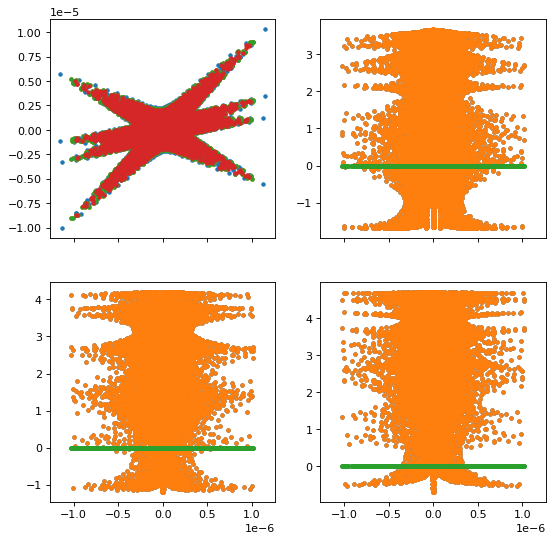

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

meshfile='sphere_s61.hdf5'
mesh=import_mesh(meshfile)

nodes=mesh['nodes']
elements=mesh['elements']
faces=mesh['faces']

unod=nodes[:,0]*2+nodes[:,1]*3+nodes[:,2]*4

u2d_local=grad2d(nodes,faces,unod,local=1)
u2d_global=grad2d(nodes,faces,unod,local=0)
u2d_tangent=compute_tangent(nodes,faces,np.array([[0,2.0,3.0,4.0]]*len(faces)))
u3d=grad3d(nodes,elements,unod)

midpoints2d=compute_midpoints2d(nodes,faces)
midpoints3d=compute_midpoints3d(nodes,elements)

fig,ax=plt.subplots(2,2,sharex=True,figsize=(8,8),dpi=80)
axs=ax.flatten()
axs[0].plot(nodes[:,0],unod,'.')
axs[0].plot(midpoints2d[:,0],np.real(u2d_local[:,0]),'.')
axs[0].plot(midpoints2d[:,0],np.real(u2d_global[:,0]),'.')
axs[0].plot(midpoints3d[:,0],np.real(u3d[:,0]),'.')

axs[1].plot(midpoints2d[:,0],np.real(u2d_global[:,1]),'.')
axs[1].plot(midpoints2d[:,0],np.real(u2d_tangent[:,1]),'.')
axs[1].plot(midpoints2d[:,0],np.real(u2d_global[:,1]-u2d_tangent[:,1]),'.')

axs[2].plot(midpoints2d[:,0],np.real(u2d_global[:,2]),'.')
axs[2].plot(midpoints2d[:,0],np.real(u2d_tangent[:,2]),'.')
axs[2].plot(midpoints2d[:,0],np.real(u2d_global[:,2]-u2d_tangent[:,2]),'.')

axs[3].plot(midpoints2d[:,0],np.real(u2d_global[:,3]),'.')
axs[3].plot(midpoints2d[:,0],np.real(u2d_tangent[:,3]),'.')
axs[3].plot(midpoints2d[:,0],np.real(u2d_global[:,3]-u2d_tangent[:,3]),'.')
plt.show()

# Test Case 1 (Subdomain/K11/K22)

In [6]:
def set_materials(mesh,physics,unod=0,freq=None,dist_factor=1,case=1):
    print('TEST CASE IS:',case)
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    rel_perm_electrolyte=physics['rel_perm_electrolyte']
    rel_perm_solid=physics['rel_perm_solid']
    diffusion_electrolyte=physics['diffusion_electrolyte']
    diffusion_stern=physics['diffusion_stern']
    mobility_electrolyte=physics['mobility_electrolyte']
    mobility_stern=physics['mobility_stern']
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
    sigma_solid=physics['sigma_solid']
    ratio_p=physics['ratio_p']
    
    sigma_stern=-ratio_p*sigma_solid
    sigma_electrolyte=-(1-ratio_p)*sigma_solid
    
    u2d=grad2d(mesh['nodes'],mesh['faces'],unod,dist_factor=dist_factor)
    u3d=grad3d(mesh['nodes'],mesh['elements'],unod,dist_factor=dist_factor)
    
    print('Setting material properties in Stern layer')
    c2d=np.zeros(nface,dtype=complex)
    alpha2d_x=np.zeros(nface,dtype=complex)
    alpha2d_y=np.zeros(nface,dtype=complex)
    alpha2d_z=np.zeros(nface,dtype=complex)

    beta2d_x=np.zeros(nface,dtype=complex)
    beta2d_y=np.zeros(nface,dtype=complex)
    beta2d_z=np.zeros(nface,dtype=complex)

    gamma2d_x=np.zeros(nface,dtype=complex)
    gamma2d_y=np.zeros(nface,dtype=complex)
    gamma2d_z=np.zeros(nface,dtype=complex)

    a2d=np.zeros(nface,dtype=complex)
    f2d=np.zeros(nface,dtype=complex)
    gs2d=0 #placeholder; not implemented yet
    qs2d=0 #placeholder; not implemented yet
    snod2d=0 #placeholder; not implemented yet
    
    c2d[in_stern]=diffusion_stern
    gamma2d_x[in_stern]=-mobility_stern*sigma_stern
    gamma2d_y[in_stern]=-mobility_stern*sigma_stern
    gamma2d_z[in_stern]=-mobility_stern*sigma_stern
    a2d[in_stern]=1j*freq
    
    print('Setting material properties in solid and electrolyte')
    print('')
    c3d=np.zeros(nelem,dtype=complex)
    alpha3d_x=np.zeros(nelem,dtype=complex)
    alpha3d_y=np.zeros(nelem,dtype=complex)
    alpha3d_z=np.zeros(nelem,dtype=complex)

    beta3d_x=np.zeros(nelem,dtype=complex)
    beta3d_y=np.zeros(nelem,dtype=complex)
    beta3d_z=np.zeros(nelem,dtype=complex)

    gamma3d_x=np.zeros(nelem,dtype=complex)
    gamma3d_y=np.zeros(nelem,dtype=complex)
    gamma3d_z=np.zeros(nelem,dtype=complex)

    a3d=np.zeros(nelem,dtype=complex)
    f3d=np.zeros(nelem,dtype=complex)
    gs3d=np.zeros(nface,dtype=complex)
    qs3d=np.zeros(nface,dtype=complex)
    snod3d=np.zeros(nnode,dtype=complex)
    
    c3d[in_electrolyte]=perm0*rel_perm_electrolyte
    c3d[in_solid]=perm0*rel_perm_solid
    gs3d[in_stern]=-sigma_electrolyte

    ze=zval*echarge #ion valence times elementary charge
    u3d[:,0]=ze*u3d[:,0]/kB/temp_K #scaled potential in elements
    a3d[:]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u3d[:,0])
    f3d[:]=-2*ze*kA*cinf*(np.sinh(u3d[:,0])-np.cosh(u3d[:,0])*u3d[:,0])
    a3d[in_solid]=0
    f3d[in_solid]=0
    
    materials={'cx2d':np.array(c2d),'cy2d':np.array(c2d),'cz2d':np.array(c2d),
               'alpha2d_x':alpha2d_x,'alpha2d_y':alpha2d_y,'alpha2d_z':alpha2d_z,
               'beta2d_x':beta2d_x,'beta2d_y':beta2d_y,'beta2d_z':beta2d_z,
               'gamma2d_x':gamma2d_x,'gamma2d_y':gamma2d_y,'gamma2d_z':gamma2d_z,
               'a2d':a2d,'f2d':f2d,'gs2d':gs2d,'qs2d':qs2d,'snod2d':snod2d,
               'cx3d':np.array(c3d),'cy3d':np.array(c3d),'cz3d':np.array(c3d),
               'alpha3d_x':alpha3d_x,'alpha3d_y':alpha3d_y,'alpha3d_z':alpha3d_z,
               'beta3d_x':beta3d_x,'beta3d_y':beta3d_y,'beta3d_z':beta3d_z,
               'gamma3d_x':gamma3d_x,'gamma3d_y':gamma3d_y,'gamma3d_z':gamma3d_z,
               'a3d':a3d,'f3d':f3d,'gs3d':gs3d,'qs3d':qs3d,'snod3d':snod3d}
    
    return materials

def build_system(mesh,materials,case=1):
    nnode=len(mesh['nodes'])
    K=csr_matrix((nnode*2,nnode*2))
    b=np.zeros(nnode*2,dtype=complex)
    K,b=assemble_Ke3d(mesh,materials,K,b,offset=(0,0),nrep=1)
    K,b=assemble_Ks3d(mesh,materials,K,b,offset=(0,0),nrep=1)
    K,b=assemble_Ke2d(mesh,materials,K,b,offset=(nnode,nnode),nrep=1)
    K,b=set_first_kind_bc3d(mesh,materials,K,b,offset=(0,0),nrep=1)
    K,b=set_inactive_nodes3d(mesh,K,b,offset=(0,0),nrep=1)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(nnode,nnode),nrep=1)
    
    return K,b

if __name__=='__main__':
    #user input
    meshfile='sphere_s61_electrolyte.hdf5'
    physfile='sphere_s61_electrolyte.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9
    #dist_factor=1
    case=1
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    materials=set_materials(mesh,physics,unod=np.zeros(len(mesh['nodes'])),
                            freq=0.1,dist_factor=dist_factor,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor=dist_factor)
    materials_scale=scale_materials(materials,dist_factor=dist_factor)
    K,b=build_system(mesh_scale,materials_scale,case=case)

    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    solution=call_solver(K/perm0,b/perm0)
    unod_list=reshape_solution(solution,nrep=1)
    output=output_unod(nodes,unod_list[0],srvfile)
    
    np.save('sphere_s61',solution)
    print('Done')


Reading group mesh from sphere_s61_electrolyte.hdf5
THE NUMBER OF ACTIVE NODES IS: 22705
THE NUMBER OF ACTIVE ELEMENTS IS: 123661
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61_electrolyte.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR SOLID PARTICLE IS: 0.02
RATIO OF THE SURFACE CHARGE DENSITY OF STERN LAYER TO SOLID PARTICLE IS: 0.5

TEST CASE IS: 1
Computing fields and field gradients on faces
Time elapsed  2.5734221935272217 sec

Computing fields and field gradients in elements
Time elapsed  4.158342123031616 sec

Setting material properties in Stern layer
Se

# Test 5 (K12/K21)

In [2]:
def set_materials(mesh,physics,u2d=0,u3d=0,freq=None,dist_factor=1,case=1):
    print('TEST CASE IS:',case)
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    rel_perm_electrolyte=physics['rel_perm_electrolyte']
    rel_perm_solid=physics['rel_perm_solid']
    diffusion_electrolyte=physics['diffusion_electrolyte']
    diffusion_stern=physics['diffusion_stern']
    mobility_electrolyte=physics['mobility_electrolyte']
    mobility_stern=physics['mobility_stern']
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
    sigma_solid=physics['sigma_solid']
    ratio_p=physics['ratio_p']
    
    sigma_stern=-ratio_p*sigma_solid
    sigma_electrolyte=-(1-ratio_p)*sigma_solid
    
    #u2d=grad2d(mesh['nodes'],mesh['faces'],unod,dist_factor=dist_factor)
    #u3d=grad3d(mesh['nodes'],mesh['elements'],unod,dist_factor=dist_factor)
    
    print('Setting material properties in Stern layer')
    c2d=np.zeros((nface,3,3),dtype=complex)
    alpha2d_x=np.zeros((nface,3,3),dtype=complex)
    alpha2d_y=np.zeros((nface,3,3),dtype=complex)
    alpha2d_z=np.zeros((nface,3,3),dtype=complex)

    beta2d_x=np.zeros((nface,3,3),dtype=complex)
    beta2d_y=np.zeros((nface,3,3),dtype=complex)
    beta2d_z=np.zeros((nface,3,3),dtype=complex)

    gamma2d_x=np.zeros((nface,3),dtype=complex)
    gamma2d_y=np.zeros((nface,3),dtype=complex)
    gamma2d_z=np.zeros((nface,3),dtype=complex)

    a2d=np.zeros((nface,3,3),dtype=complex)
    f2d=np.zeros((nface,3),dtype=complex)
    gs2d=0j #placeholder; not implemented yet
    qs2d=0j #placeholder; not implemented yet
    snod2d=0j #placeholder; not implemented yet
    
#     c2d[in_stern]=diffusion_stern
#     gamma2d_x[in_stern]=-mobility_stern*sigma_stern
#     gamma2d_y[in_stern]=-mobility_stern*sigma_stern
#     gamma2d_z[in_stern]=-mobility_stern*sigma_stern
#     a2d[in_stern]=1j*freq
    
    c2d[in_stern,2,2]=diffusion_stern
    gamma2d_x[in_stern,2]=-mobility_stern*sigma_stern #coupled coefficient
    gamma2d_y[in_stern,2]=-mobility_stern*sigma_stern #coupled coefficient
    gamma2d_z[in_stern,2]=-mobility_stern*sigma_stern #coupled coefficient
    a2d[in_stern,0,0]=1j*freq
    a2d[in_stern,1,1]=1j*freq
    a2d[in_stern,2,2]=1j*freq
    
    print('Setting material properties in solid and electrolyte')
    print('')
    c3d=np.zeros((nelem,3,3),dtype=complex)
    alpha3d_x=np.zeros((nelem,3,3),dtype=complex)
    alpha3d_y=np.zeros((nelem,3,3),dtype=complex)
    alpha3d_z=np.zeros((nelem,3,3),dtype=complex)

    beta3d_x=np.zeros((nelem,3,3),dtype=complex)
    beta3d_y=np.zeros((nelem,3,3),dtype=complex)
    beta3d_z=np.zeros((nelem,3,3),dtype=complex)

    gamma3d_x=np.zeros((nelem,3),dtype=complex)
    gamma3d_y=np.zeros((nelem,3),dtype=complex)
    gamma3d_z=np.zeros((nelem,3),dtype=complex)

    a3d=np.zeros((nelem,3,3),dtype=complex)
    f3d=np.zeros((nelem,3),dtype=complex)
    gs3d=np.zeros((nface,3),dtype=complex)
    qs3d=np.zeros((nface,3,3),dtype=complex)
    snod3d=np.zeros((nnode,3),dtype=complex)
            
    c3d[in_electrolyte,0,0]=diffusion_electrolyte
    c3d[in_electrolyte,1,1]=diffusion_electrolyte
    c3d[in_electrolyte,2,2]=perm0*rel_perm_electrolyte

    c3d[in_electrolyte,0,2]=-mobility_electrolyte*cinf*np.exp(u3d[in_electrolyte,0]*echarge/kB/temp_K)
    c3d[in_electrolyte,1,2]=mobility_electrolyte*cinf*np.exp(-u3d[in_electrolyte,0]*echarge/kB/temp_K)

    c3d[in_solid,0,0]=0
    c3d[in_solid,1,1]=0
    c3d[in_solid,2,2]=perm0*rel_perm_solid

    alpha3d_x[in_electrolyte,0,0]=-mobility_electrolyte*u3d[in_electrolyte,1] #to be verified for vectors inside matrix
    alpha3d_y[in_electrolyte,0,0]=-mobility_electrolyte*u3d[in_electrolyte,2] #to be verified for vectors inside matrix
    alpha3d_z[in_electrolyte,0,0]=-mobility_electrolyte*u3d[in_electrolyte,3] #to be verified for vectors inside matrix

    alpha3d_x[in_electrolyte,1,1]=mobility_electrolyte*u3d[in_electrolyte,1] #to be verified for vectors inside matrix
    alpha3d_y[in_electrolyte,1,1]=mobility_electrolyte*u3d[in_electrolyte,2] #to be verified for vectors inside matrix
    alpha3d_z[in_electrolyte,1,1]=mobility_electrolyte*u3d[in_electrolyte,3] #to be verified for vectors inside matrix

    a3d[:,0,0]=1j*freq
    a3d[:,1,1]=1j*freq

    a3d[in_electrolyte,2,0]=kA*echarge
    a3d[in_electrolyte,2,1]=-kA*echarge

    gs3d[in_stern,0]=0 #coupled coefficient; need to verify sign
    gs3d[in_stern,1]=0 #coupled coefficient; need to verify sign
    gs3d[in_stern,2]=1 #coupled coefficient; need to verify sign

    nodes=mesh['nodes']
    with_first_kind_bc=mesh['with_first_kind_bc']
    snod3d[with_first_kind_bc,2]=nodes[with_first_kind_bc,0]*1e6 #need to be updated
    
    materials={'cx2d':np.array(c2d),'cy2d':np.array(c2d),'cz2d':np.array(c2d),
               'alpha2d_x':alpha2d_x,'alpha2d_y':alpha2d_y,'alpha2d_z':alpha2d_z,
               'beta2d_x':beta2d_x,'beta2d_y':beta2d_y,'beta2d_z':beta2d_z,
               'gamma2d_x':gamma2d_x,'gamma2d_y':gamma2d_y,'gamma2d_z':gamma2d_z,
               'a2d':a2d,'f2d':f2d,'gs2d':gs2d,'qs2d':qs2d,'snod2d':snod2d,
               'cx3d':np.array(c3d),'cy3d':np.array(c3d),'cz3d':np.array(c3d),
               'alpha3d_x':alpha3d_x,'alpha3d_y':alpha3d_y,'alpha3d_z':alpha3d_z,
               'beta3d_x':beta3d_x,'beta3d_y':beta3d_y,'beta3d_z':beta3d_z,
               'gamma3d_x':gamma3d_x,'gamma3d_y':gamma3d_y,'gamma3d_z':gamma3d_z,
               'a3d':a3d,'f3d':f3d,'gs3d':gs3d,'qs3d':qs3d,'snod3d':snod3d}
    
    return materials

def build_system(mesh,materials,case=1):
    nnode=len(mesh['nodes'])
    mats_zero_gs3d_zero_gamma2d=copy.deepcopy(materials)
    mats_zero_gs3d_zero_gamma2d['gs3d'][:]=0
    mats_zero_gs3d_zero_gamma2d['gamma2d_x'][:]=0
    mats_zero_gs3d_zero_gamma2d['gamma2d_y'][:]=0
    mats_zero_gs3d_zero_gamma2d['gamma2d_z'][:]=0

    K=csr_matrix((nnode*6,nnode*6),dtype=complex)
    b=np.zeros(nnode*6,dtype=complex)
    K,b=assemble_Ke3d(mesh,mats_zero_gs3d_zero_gamma2d,K,b,offset=(0,0),nrep=3) #K11 element
    K,b=assemble_Ks3d(mesh,mats_zero_gs3d_zero_gamma2d,K,b,offset=(0,0),nrep=3) #K11 face
    K,b=assemble_Ke2d(mesh,mats_zero_gs3d_zero_gamma2d,K,b,offset=(nnode*3,nnode*3),nrep=3) #K22 element

    K,b=assemble_Ks3d2d(mesh,materials,K,b,offset=(0,nnode*3),nrep=3) #coupled term of K12
    K,b=assemble_Ke2d3d(mesh,materials,K,b,offset=(nnode*3,0),nrep=3) #coupled term of K12

    K,b=set_first_kind_bc3d(mesh,materials,K,b,offset=(0,0),nrep=3) #K11 1st kind b.c.
    K,b=set_inactive_nodes3d(mesh,K,b,offset=(0,0),nrep=3)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(nnode*3,nnode*3),nrep=3)
    
    return K,b

def set_materials2d(mesh,physics,u=0,freq=None,case=1):
    print('Setting materials in stern layer using predefined cases')
    case=np.maximum(1,int(case))
    case=np.minimum(10,int(case))
    print('TEST CASE IS:',case)
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    rel_perm_electrolyte=physics['rel_perm_electrolyte']
    rel_perm_solid=physics['rel_perm_solid']
    diffusion_electrolyte=physics['diffusion_electrolyte']
    diffusion_stern=physics['diffusion_stern']
    mobility_electrolyte=physics['mobility_electrolyte']
    mobility_stern=physics['mobility_stern']
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
    sigma_solid=physics['sigma_solid']
    ratio_p=physics['ratio_p']
    
    c=np.zeros((nface,3,3),dtype=complex)
    alpha_x=np.zeros((nface,3,3),dtype=complex)
    alpha_y=np.zeros((nface,3,3),dtype=complex)
    alpha_z=np.zeros((nface,3,3),dtype=complex)

    beta_x=np.zeros((nface,3,3),dtype=complex)
    beta_y=np.zeros((nface,3,3),dtype=complex)
    beta_z=np.zeros((nface,3,3),dtype=complex)

    gamma_x=np.zeros((nface,3),dtype=complex)
    gamma_y=np.zeros((nface,3),dtype=complex)
    gamma_z=np.zeros((nface,3),dtype=complex)

    a=np.zeros((nface,3,3),dtype=complex)
    f=np.zeros((nface,3),dtype=complex)
    gs=0j #placeholder; not implemented yet
    qs=0j #placeholder; not implemented yet
    snod=0j #placeholder; not implemented yet

    #phys_factor=1/diffusion_stern
    phys_factor=1
    c[in_stern,2,2]=diffusion_stern*phys_factor

    gamma_x[in_stern,2]=mobility_stern*sigma_solid*ratio_p*phys_factor #coupled coefficient
    gamma_y[in_stern,2]=mobility_stern*sigma_solid*ratio_p*phys_factor #coupled coefficient
    gamma_z[in_stern,2]=mobility_stern*sigma_solid*ratio_p*phys_factor #coupled coefficient

    a[in_stern,0,0]=1j*freq*phys_factor
    a[in_stern,1,1]=1j*freq*phys_factor
    a[in_stern,2,2]=1j*freq*phys_factor

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}
    
    return materials
    
def set_materials3d(mesh,physics,u=0,freq=None,case=1):
    print('Setting materials in solid and electrolyte using predefined cases')
    case=np.maximum(1,int(case))
    case=np.minimum(10,int(case))
    print('TEST CASE IS:',case)
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    rel_perm_electrolyte=physics['rel_perm_electrolyte']
    rel_perm_solid=physics['rel_perm_solid']
    diffusion_electrolyte=physics['diffusion_electrolyte']
    diffusion_stern=physics['diffusion_stern']
    mobility_electrolyte=physics['mobility_electrolyte']
    mobility_stern=physics['mobility_stern']
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
    sigma_solid=physics['sigma_solid']
    ratio_p=physics['ratio_p']

    c=np.zeros((nelem,3,3),dtype=complex)
    alpha_x=np.zeros((nelem,3,3),dtype=complex)
    alpha_y=np.zeros((nelem,3,3),dtype=complex)
    alpha_z=np.zeros((nelem,3,3),dtype=complex)

    beta_x=np.zeros((nelem,3,3),dtype=complex)
    beta_y=np.zeros((nelem,3,3),dtype=complex)
    beta_z=np.zeros((nelem,3,3),dtype=complex)

    gamma_x=np.zeros((nelem,3),dtype=complex)
    gamma_y=np.zeros((nelem,3),dtype=complex)
    gamma_z=np.zeros((nelem,3),dtype=complex)

    a=np.zeros((nelem,3,3),dtype=complex)
    f=np.zeros((nelem,3),dtype=complex)
    gs=np.zeros((nface,3),dtype=complex)
    qs=np.zeros((nface,3,3),dtype=complex)
    snod=np.zeros((nnode,3),dtype=complex)

    #phys_factor=1/perm0
    phys_factor=1
    c[in_electrolyte,0,0]=diffusion_electrolyte*phys_factor
    c[in_electrolyte,1,1]=diffusion_electrolyte*phys_factor
    c[in_electrolyte,2,2]=perm0*rel_perm_electrolyte*phys_factor

    c[in_electrolyte,0,2]=-mobility_electrolyte*cinf*np.exp(u[in_electrolyte,0]*echarge/kB/temp_K)*phys_factor
    c[in_electrolyte,1,2]=mobility_electrolyte*cinf*np.exp(-u[in_electrolyte,0]*echarge/kB/temp_K)*phys_factor

    c[in_solid,0,0]=0
    c[in_solid,1,1]=0
    c[in_solid,2,2]=perm0*rel_perm_solid*phys_factor

    alpha_x[in_electrolyte,0,0]=-mobility_electrolyte*u[in_electrolyte,1]*phys_factor #to be verified for vectors inside matrix
    alpha_y[in_electrolyte,0,0]=-mobility_electrolyte*u[in_electrolyte,2]*phys_factor #to be verified for vectors inside matrix
    alpha_z[in_electrolyte,0,0]=-mobility_electrolyte*u[in_electrolyte,3]*phys_factor #to be verified for vectors inside matrix

    alpha_x[in_electrolyte,1,1]=mobility_electrolyte*u[in_electrolyte,1]*phys_factor #to be verified for vectors inside matrix
    alpha_y[in_electrolyte,1,1]=mobility_electrolyte*u[in_electrolyte,2]*phys_factor #to be verified for vectors inside matrix
    alpha_z[in_electrolyte,1,1]=mobility_electrolyte*u[in_electrolyte,3]*phys_factor #to be verified for vectors inside matrix

    a[:,0,0]=1j*freq*phys_factor
    a[:,1,1]=1j*freq*phys_factor

    a[in_electrolyte,2,0]=kA*echarge*phys_factor
    a[in_electrolyte,2,1]=-kA*echarge*phys_factor

    gs[in_stern,0]=0 #coupled coefficient; need to verify sign
    gs[in_stern,1]=0 #coupled coefficient; need to verify sign
    gs[in_stern,2]=1*phys_factor #coupled coefficient; need to verify sign

    nodes=mesh['nodes']
    with_first_kind_bc=mesh['with_first_kind_bc']
    snod[with_first_kind_bc,2]=nodes[with_first_kind_bc,0]*1e6 #need to be updated
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}
    
    return materials

if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    #dist_factor=1e9
    dist_factor=1
    case=5
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    #ansol=ansol_sphere(mesh['nodes'],a=5e-9,rel_perm=78.5,temp_K=298,
    #                  cinf=100,zval=1,zeta=0.01,gradflag=1)
    midpoints3d=compute_midpoints3d(mesh['nodes'],mesh['elements'])
    ansol=ansol_sphere(midpoints3d,a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)

    materials=set_materials(mesh,physics,u2d=0,u3d=ansol,
                            freq=10,dist_factor=dist_factor,case=case)
#     materials2d=set_materials2d(mesh,physics,u=0,freq=10,case=case)
#     materials3d=set_materials3d(mesh,physics,u=ansol,freq=10,case=case)
#     materials=combine_materials(materials2d,materials3d)
    mesh_scale=scale_mesh(mesh,dist_factor=dist_factor)
    materials_scale=scale_materials(materials,dist_factor=dist_factor)
    K,b=build_system(mesh_scale,materials_scale,case=case)
    
#     midpoints3d=compute_midpoints3d(mesh['nodes'],mesh['elements'])
#     ansol=ansol_sphere(midpoints3d,a=5e-9,rel_perm=78.5,temp_K=298,
#                        cinf=100,zval=1,zeta=0.01,gradflag=1)
#     materials2d=set_materials2d(mesh,physics,u=0,freq=10,case=case)
#     materials3d=set_materials3d(mesh,physics,u=ansol,freq=10,case=case)
# #     materials=combine_materials(materials2d,materials3d)
# #     mesh_scale=scale_mesh(mesh,dist_factor=dist_factor)
# #     materials_scale=scale_materials(materials,dist_factor=dist_factor)
# #     K,b=build_system(mesh_scale,materials_scale,case=case)
    
#     nnode=len(mesh['nodes'])
#     mats3d_zero_gs=copy.deepcopy(materials3d)
#     mats3d_zero_gs['gs'][:]=0

#     mats2d_zero_gamma=copy.deepcopy(materials2d)
#     mats2d_zero_gamma['gamma_x'][:]=0
#     mats2d_zero_gamma['gamma_y'][:]=0
#     mats2d_zero_gamma['gamma_z'][:]=0

#     K=csr_matrix((nnode*6,nnode*6),dtype=complex)
#     b=np.zeros(nnode*6,dtype=complex)
#     K,b=assemble_Ke3d(mesh,mats3d_zero_gs,K,b,offset=(0,0),nrep=3) #K11 element
#     K,b=assemble_Ks3d(mesh,mats3d_zero_gs,K,b,offset=(0,0),nrep=3) #K11 face
#     K,b=assemble_Ke2d(mesh,mats2d_zero_gamma,K,b,offset=(nnode*3,nnode*3),nrep=3) #K22 element

#     K,b=assemble_Ks3d2d(mesh,materials3d,K,b,offset=(0,nnode*3),nrep=3) #coupled term of K12
#     K,b=assemble_Ke2d3d(mesh,materials2d,K,b,offset=(nnode*3,0),nrep=3) #coupled term of K12

#     K,b=set_first_kind_bc3d(mesh,materials3d,K,b,offset=(0,0),nrep=3) #K11 1st kind b.c.
#     K,b=set_inactive_nodes3d(mesh,K,b,offset=(0,0),nrep=3)
#     K,b=set_inactive_nodes2d(mesh,K,b,offset=(nnode*3,nnode*3),nrep=3)

    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    #solution=call_solver(K/perm0,b/perm0)
    solution=call_solver(K,b)
    unod_list=reshape_solution(solution,nrep=3)
    output=output_unod(nodes,unod_list[0],srvfile)
    
    np.save('sphere_s61',solution)
    print('Done')


Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR SOLID PARTICLE IS: 0.02
RATIO OF THE SURFACE CHARGE DENSITY OF STERN LAYER TO SOLID PARTICLE IS: 0.5

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBY

In [77]:
midpoints3d=compute_midpoints3d(mesh['nodes'],mesh['elements'])
ansol=ansol_sphere(midpoints3d,a=5e-9,rel_perm=78.5,temp_K=298,
                   cinf=100,zval=1,zeta=0.01,gradflag=1)
materials2d=set_materials2d(mesh,physics,u=0,freq=10,case=case)
materials3d=set_materials3d(mesh,physics,u=ansol,freq=10,case=case)


Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Setting materials in stern layer using predefined cases
TEST CASE IS: 5

Setting materials in solid and electrolyte using predefined cases
TEST CASE IS: 5



In [96]:
def validate_materials(materials,materials2d,materials3d):
    keys=list(materials.keys())
    keys2d=list(materials2d.keys())
    keys3d=list(materials3d.keys())
        
    for i in range(len(keys2d)):
        key=keys[i]
        key2d=keys2d[i]
        print(key,key2d,np.max(np.abs(materials2d[key2d]-materials[key])))
    
    print('')
    for i in range(len(keys3d)):
        key=keys[i+len(keys2d)]
        key3d=keys3d[i]
        print(key,key3d,np.max(np.abs(materials3d[key3d]-materials[key])))

    
    return
validate_materials(materials,materials2d,materials3d)
# print(np.max(np.abs(materials2d['cx'])-materials['cx2d']))
# print(np.max(np.abs(materials2d['gamma_x'])-materials['gamma2d_x']))

# print(np.max(np.abs(materials2d['gamma_x'])),np.max(np.abs(materials['gamma2d_x'])))
# print(np.max(np.abs(materials2d['gamma_y'])),np.max(np.abs(materials['gamma2d_y'])))
# print(np.max(np.abs(materials2d['gamma_z'])),np.max(np.abs(materials['gamma2d_z'])))

cx2d cx 0.0
cy2d cy 0.0
cz2d cz 0.0
alpha2d_x alpha_x 0.0
alpha2d_y alpha_y 0.0
alpha2d_z alpha_z 0.0
beta2d_x beta_x 0.0
beta2d_y beta_y 0.0
beta2d_z beta_z 0.0
gamma2d_x gamma_x 0.0
gamma2d_y gamma_y 0.0
gamma2d_z gamma_z 0.0
a2d a 9.9
f2d f 0.0
gs2d gs 0.0
qs2d qs 0.0
snod2d snod 0.0

cx3d cx 0.0
cy3d cy 0.0
cz3d cz 0.0
alpha3d_x alpha_x 0.0
alpha3d_y alpha_y 0.0
alpha3d_z alpha_z 0.0
beta3d_x beta_x 0.0
beta3d_y beta_y 0.0
beta3d_z beta_z 0.0
gamma3d_x gamma_x 0.0
gamma3d_y gamma_y 0.0
gamma3d_z gamma_z 0.0
a3d a 9.9
f3d f 0.0
gs3d gs 0.0
qs3d qs 0.0
snod3d snod 0.0


# Test Case 2 (Nrep/K11/K22)

In [59]:
if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9
    case=2
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    ansol=ansol_sphere(mesh['midpoints'],a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)

    materials2d=set_materials2d(mesh,physics,u=0,freq=0.1,case=case)
    materials3d=set_materials3d(mesh,physics,u=0,freq=0.1,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)
    #mesh_scale,materials3d_scale=scale_distance(mesh,materials3d,dist_factor)
    #mesh_subset,materials3d_subset=set_subdomains(mesh_scale,materials3d_scale)
    #K,b=build_system(mesh_subset,materials3d_subset,case=case)
    
    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    #unod=call_solver(K/perm0,b/perm0)
    nnode=len(nodes)
    nrep=int(len(b)/len(nodes)/2)
    unod=call_solver(K,b)
    unod1=np.reshape(unod[:nnode*nrep],(nnode,nrep))
    unod2=np.reshape(unod[nnode*nrep:],(nnode,nrep))
    
    output=output_unod(nodes,unod1[:,0],srvfile)
    u2d=grad2d(nodes,faces,unod1[:,0])
    u3d=grad3d(nodes,elements,unod1[:,0])
    np.save('sphere_s61',unod)
    print('Done')


Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR STEADY STATE IS: -0.01

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Setting materials in stern layer using pre

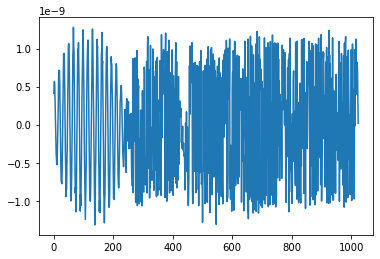

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

fig,ax=plt.subplots()
ax.plot(np.real(unod2[nind_stern,-1]))
plt.show()

# Test Case 3 (K12 was tested)

In [65]:
if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9
    case=3
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    ansol=ansol_sphere(mesh['midpoints'],a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)

    materials2d=set_materials2d(mesh,physics,u=0,freq=0.1,case=case)
    materials3d=set_materials3d(mesh,physics,u=0,freq=0.1,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)
    #mesh_scale,materials3d_scale=scale_distance(mesh,materials3d,dist_factor)
    #mesh_subset,materials3d_subset=set_subdomains(mesh_scale,materials3d_scale)
    #K,b=build_system(mesh_subset,materials3d_subset,case=case)
    
    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    #unod=call_solver(K/perm0,b/perm0)
    nnode=len(nodes)
    nrep=int(len(b)/len(nodes)/2)
    unod=call_solver(K,b)
    unod1=np.reshape(unod[:nnode*nrep],(nnode,nrep))
    unod2=np.reshape(unod[nnode*nrep:],(nnode,nrep))
    
    output=output_unod(nodes,unod1[:,0],srvfile)
    u2d=grad2d(nodes,faces,unod1[:,0])
    u3d=grad3d(nodes,elements,unod1[:,0])
    np.save('sphere_s61',unod)
    print('Done')


Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR STEADY STATE IS: -0.01

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Setting materials in stern layer using pre

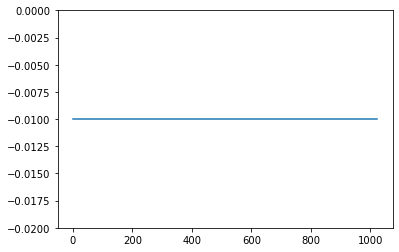

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

# print(np.real(unod2[nind_stern,-1]))
fig,ax=plt.subplots()
ax.plot(np.real(unod2[nind_stern,-1]))
ax.set_ylim([-0.02,0])
plt.show()

# Test Case 4 (K21 was tested)

In [72]:
if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9
    case=4
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    ansol=ansol_sphere(mesh['midpoints'],a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)

    materials2d=set_materials2d(mesh,physics,u=0,freq=0.1,case=case)
    materials3d=set_materials3d(mesh,physics,u=0,freq=0.1,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)
    #mesh_scale,materials3d_scale=scale_distance(mesh,materials3d,dist_factor)
    #mesh_subset,materials3d_subset=set_subdomains(mesh_scale,materials3d_scale)
    #K,b=build_system(mesh_subset,materials3d_subset,case=case)
    
    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    #unod=call_solver(K/perm0,b/perm0)
    nnode=len(nodes)
    nrep=int(len(b)/len(nodes)/2)
    unod=call_solver(K,b)
    unod1=np.reshape(unod[:nnode*nrep],(nnode,nrep))
    unod2=np.reshape(unod[nnode*nrep:],(nnode,nrep))
    
    output=output_unod(nodes,unod1[:,0],srvfile)
    u2d=grad2d(nodes,faces,unod1[:,0])
    u3d=grad3d(nodes,elements,unod1[:,0])
    np.save('sphere_s61',unod)
    print('Done')


Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR STEADY STATE IS: -0.01

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: -0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Setting materials in stern layer using pr

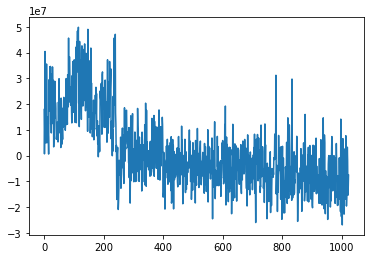

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt

# nface=len(faces[:,0])
# midpoints=np.zeros((nface,3))
# for i in range(0,nface):
#     for j in range(0,3):
#         midpoints[i,j]=.25*sum(nodes[faces[i,:],j])

# ansol=ansol_sphere(midpoints,a=5e-9,rel_perm=78.5,temp_K=298,
#                    cinf=100,zval=1,zeta=0.01,gradflag=1)
# tmp=-2*echarge*kA*100*np.sinh(ansol[:,0]*echarge/kB/298)
# print(tmp[in_stern])

fig,ax=plt.subplots()
ax.plot(np.real(unod2[nind_stern,-1]))
plt.show()

Saving results to sphere_complex.srv.out



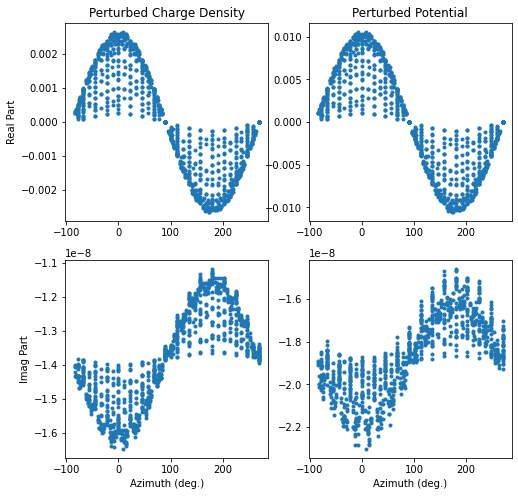

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

# meshfile='sphere_s61.hdf5'
# physfile='sphere_s61.hdf5'
# srvfile='sphere_complex.srv'
# dist_factor=1e9
# case=5

# #setup mesh and material properties
# mesh=import_mesh(meshfile)
# physics=import_physics(physfile)

# #initialize unknows
# nodes=mesh['nodes']
# elements=mesh['elements']
# faces=mesh['faces']

# in_active_zones=mesh['in_active_zones']
# in_stern=mesh['in_stern']
# nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
# nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))

# #unod=call_solver(K/perm0,b/perm0)
# nnode=len(nodes)
# nrep=3
# unod=np.load('sphere_s61.npy')
# unod1=np.reshape(unod[:nnode*nrep],(nnode,nrep))
# unod2=np.reshape(unod[nnode*nrep:],(nnode,nrep))

output=output_unod(nodes,unod1[:,-1],srvfile)
# in_electrolyte=mesh['in_electrolyte']
# in_solid=mesh['in_solid']
# print(materials3d['cx'][in_electrolyte,0,0])
# print(materials3d['cx'][in_electrolyte,0,2])
# print(materials3d['cx'][in_electrolyte,2,2])

# print(materials3d['alpha_x'][in_electrolyte,0,0])
# print(materials3d['alpha_y'][in_electrolyte,0,0])
# print(materials3d['alpha_z'][in_electrolyte,0,0])

# print(np.sum(materials3d['alpha_z'][in_solid,:2,:2]))
# print(materials3d['a'][in_solid,2,2])

# print(physics['mobility_electrolyte'])
# print(echarge*kA)

def cartesian2spherical(x,y,z):
    rho=np.sqrt(x**2+y**2+z**2)
    theta=np.arccos(z/rho)
    #phi=np.arctan2(y/x)
    phi=np.zeros_like(rho)+np.pi/2
    mask=x>0
    phi[mask]=np.arctan(y[mask]/x[mask])
    mask=x<0
    phi[mask]=np.arctan(y[mask]/x[mask])+np.pi
    
    return rho,theta,phi

fig,ax=plt.subplots(2,2,figsize=(8,8))
axs=ax.flatten()

rho,theta,phi=cartesian2spherical(nodes[nind_stern,0],nodes[nind_stern,1],nodes[nind_stern,2])
# print(min(phi*180/np.pi))
# print(max(phi*180/np.pi))
axs[0].plot(phi*180/np.pi,np.real(unod2[nind_stern,-1]),'.')
axs[1].plot(phi*180/np.pi,np.real(unod1[nind_stern,-1]),'.')

axs[2].plot(phi*180/np.pi,np.imag(unod2[nind_stern,-1]),'.')
axs[3].plot(phi*180/np.pi,np.imag(unod1[nind_stern,-1]),'.')

axs[0].set_title('Perturbed Charge Density')
axs[1].set_title('Perturbed Potential')

axs[0].set_ylabel('Real Part')
axs[2].set_ylabel('Imag Part')

axs[2].set_xlabel('Azimuth (deg.)')
axs[3].set_xlabel('Azimuth (deg.)')
plt.show()

# fig,ax=plt.subplots()
# # ax.plot(nodes[nind_stern,0],nodes[nind_stern,1],'.')
# # ax.axis('equal')
# mask=(nodes[nind_stern,0]>0)&(nodes[nind_stern])

# Test 6 (Check Test 5 results)

In [10]:
if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    #dist_factor=1e9
    dist_factor=1
    case=6
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    #ansol=ansol_sphere(mesh['midpoints'],a=5e-9,rel_perm=78.5,temp_K=298,
    #                   cinf=100,zval=1,zeta=0.01,gradflag=1)
    nnode=len(mesh['nodes'])
    nrep=3
    unod=np.load('sphere_s61_test5_1MV.npy')
    unod1=np.reshape(unod[:nnode*nrep],(nnode,nrep))
    unod2=np.reshape(unod[nnode*nrep:],(nnode,nrep))
    u2d_1=grad2d(mesh['nodes'],mesh['faces'],unod1[:,2])
    u2d_2=grad2d(mesh['nodes'],mesh['faces'],unod2[:,2])
    u3d_0=grad3d(mesh['nodes'],mesh['elements'],unod1[:,0])
    u3d_1=grad3d(mesh['nodes'],mesh['elements'],unod1[:,1])

    materials2d=set_materials2d(mesh,physics,u=u2d_1,freq=10,case=case)
    materials3d=set_materials3d(mesh,physics,u=[u3d_0,u3d_1,u2d_2],freq=10,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)
    #mesh_scale,materials3d_scale=scale_distance(mesh,materials3d,dist_factor)
    #mesh_subset,materials3d_subset=set_subdomains(mesh_scale,materials3d_scale)
    #K,b=build_system(mesh_subset,materials3d_subset,case=case)
    
    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    #unod=call_solver(K/perm0,b/perm0)
    nnode=len(nodes)
    nrep=int(len(b)/len(nodes)/2)
    unod=call_solver(K,b)
    unod1=np.reshape(unod[:nnode*nrep],(nnode,nrep))
    unod2=np.reshape(unod[nnode*nrep:],(nnode,nrep))
    
    #output=output_unod(nodes,unod1[:,0],srvfile)
    #u2d=grad2d(nodes,faces,unod1[:,0])
    #u3d=grad3d(nodes,elements,unod1[:,0])
    #np.save('sphere_s61',unod)
    print('Done')


Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR SOLID PARTICLE IS: 0.02
RATIO OF THE SURFACE CHARGE DENSITY OF STERN LAYER TO SOLID PARTICLE IS: 0.5

Computing fields and field gradients on faces
Time elapsed  2.387162446975708 sec

Computing fields and field gradients on faces
Time elapsed  2.391893148422241 sec

Computing fields and field gradients in elements
Time elapsed  4.250657081604004 sec

Com

In [19]:
print(u3d_1[:,0])

NameError: name 'u3d_1' is not defined

Saving results to sphere_complex.srv.out

Computing fields and field gradients on faces
Time elapsed  2.392139434814453 sec



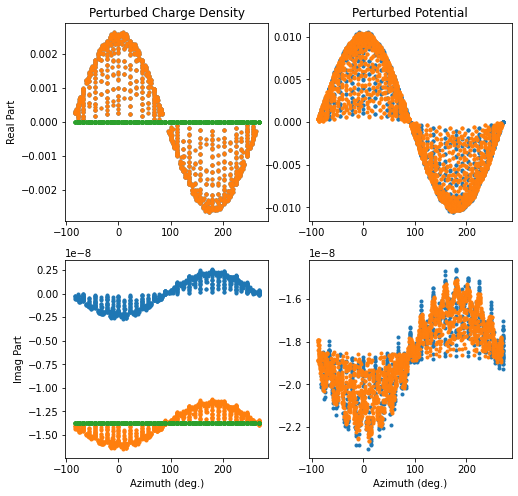

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# meshfile='sphere_s61.hdf5'
# physfile='sphere_s61.hdf5'
# srvfile='sphere_complex.srv'
# dist_factor=1e9
# case=5

# #setup mesh and material properties
# mesh=import_mesh(meshfile)
# physics=import_physics(physfile)

# #initialize unknows
# nodes=mesh['nodes']
# elements=mesh['elements']
# faces=mesh['faces']

# in_active_zones=mesh['in_active_zones']
# in_stern=mesh['in_stern']
# nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
# nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))

# #unod=call_solver(K/perm0,b/perm0)
# nnode=len(nodes)
# nrep=3
# unod=np.load('sphere_s61.npy')
# unod1=np.reshape(unod[:nnode*nrep],(nnode,nrep))
# unod2=np.reshape(unod[nnode*nrep:],(nnode,nrep))

output=output_unod(nodes,unod1[:,-1],srvfile)
# in_electrolyte=mesh['in_electrolyte']
# in_solid=mesh['in_solid']
# print(materials3d['cx'][in_electrolyte,0,0])
# print(materials3d['cx'][in_electrolyte,0,2])
# print(materials3d['cx'][in_electrolyte,2,2])

# print(materials3d['alpha_x'][in_electrolyte,0,0])
# print(materials3d['alpha_y'][in_electrolyte,0,0])
# print(materials3d['alpha_z'][in_electrolyte,0,0])

# print(np.sum(materials3d['alpha_z'][in_solid,:2,:2]))
# print(materials3d['a'][in_solid,2,2])

# print(physics['mobility_electrolyte'])
# print(echarge*kA)
# print(u2d[in_stern,:])

def cartesian2spherical(x,y,z):
    rho=np.sqrt(x**2+y**2+z**2)
    theta=np.arccos(z/rho)
    #phi=np.arctan2(y/x)
    phi=np.zeros_like(rho)+np.pi/2
    mask=x>0
    phi[mask]=np.arctan(y[mask]/x[mask])
    mask=x<0
    phi[mask]=np.arctan(y[mask]/x[mask])+np.pi
    
    return rho,theta,phi

fig,ax=plt.subplots(2,2,figsize=(8,8))
axs=ax.flatten()

rho,theta,phi=cartesian2spherical(nodes[nind_stern,0],nodes[nind_stern,1],nodes[nind_stern,2])
nface=len(faces[:,0])
midpoints=np.zeros((nface,3))
for i in range(0,nface):
    for j in range(0,3):
        midpoints[i,j]=.25*sum(nodes[faces[i,:],j])
rho2,theta2,phi2=cartesian2spherical(midpoints[in_stern,0],midpoints[in_stern,1],midpoints[in_stern,2])
unod_tmp=np.load('sphere_s61_test5_1MV.npy')
unod1_tmp=np.reshape(unod_tmp[:nnode*nrep],(nnode,nrep))
unod2_tmp=np.reshape(unod_tmp[nnode*nrep:],(nnode,nrep))
u2d_tmp=grad2d(mesh['nodes'],mesh['faces'],unod1_tmp[:,0])

# print(min(phi*180/np.pi))
# print(max(phi*180/np.pi))
axs[0].plot(phi*180/np.pi,np.real(unod2[nind_stern,-1]),'.')
axs[0].plot(phi*180/np.pi,np.real(unod2_tmp[nind_stern,-1]),'.')
axs[0].plot(phi*180/np.pi,np.real(unod2_tmp[nind_stern,-1])-np.real(unod2[nind_stern,-1]),'.')


axs[1].plot(phi*180/np.pi,np.real(unod1_tmp[nind_stern,-1]),'.')
axs[1].plot(phi2*180/np.pi,np.real(u2d_1[in_stern,0]),'.')

axs[2].plot(phi*180/np.pi,np.imag(unod2[nind_stern,-1]),'.')
axs[2].plot(phi*180/np.pi,np.imag(unod2_tmp[nind_stern,-1]),'.')
axs[2].plot(phi*180/np.pi,np.imag(unod2_tmp[nind_stern,-1])-np.imag(unod2[nind_stern,-1]),'.')

axs[3].plot(phi*180/np.pi,np.imag(unod1_tmp[nind_stern,-1]),'.')
axs[3].plot(phi2*180/np.pi,np.imag(u2d_1[in_stern,0]),'.')

axs[0].set_title('Perturbed Charge Density')
axs[1].set_title('Perturbed Potential')

axs[0].set_ylabel('Real Part')
axs[2].set_ylabel('Imag Part')

axs[2].set_xlabel('Azimuth (deg.)')
axs[3].set_xlabel('Azimuth (deg.)')
plt.show()

# fig,ax=plt.subplots()
# # ax.plot(nodes[nind_stern,0],nodes[nind_stern,1],'.')
# # ax.axis('equal')
# mask=(nodes[nind_stern,0]>0)&(nodes[nind_stern])

# Display Results

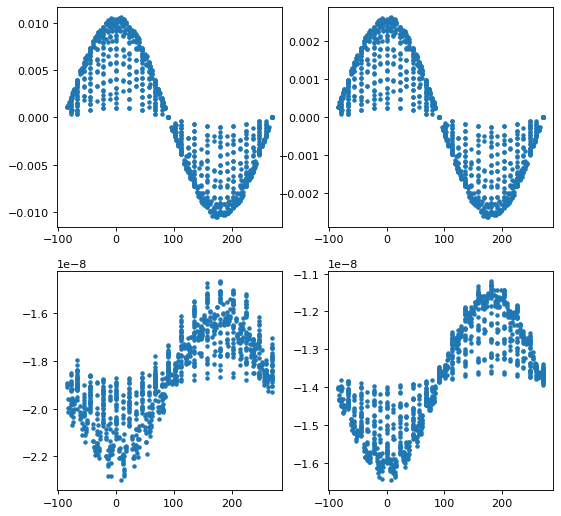

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

rho,theta,phi=cartesian2spherical(nodes[nind_stern,0],nodes[nind_stern,1],nodes[nind_stern,2])

fig,ax=plt.subplots(2,2,sharey=False,figsize=(8,8),dpi=80)
axs=ax.flatten()
axs[0].plot(phi*180/np.pi,np.real(unod_list[2][nind_stern]),'.')
axs[1].plot(phi*180/np.pi,np.real(unod_list[5][nind_stern]),'.')

axs[2].plot(phi*180/np.pi,np.imag(unod_list[2][nind_stern]),'.')
axs[3].plot(phi*180/np.pi,np.imag(unod_list[5][nind_stern]),'.')

plt.show()

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Saving results to sphere_complex.srv.out

Saving results to sphere_complex.srv.out

Saving results to sphere_complex.srv.out



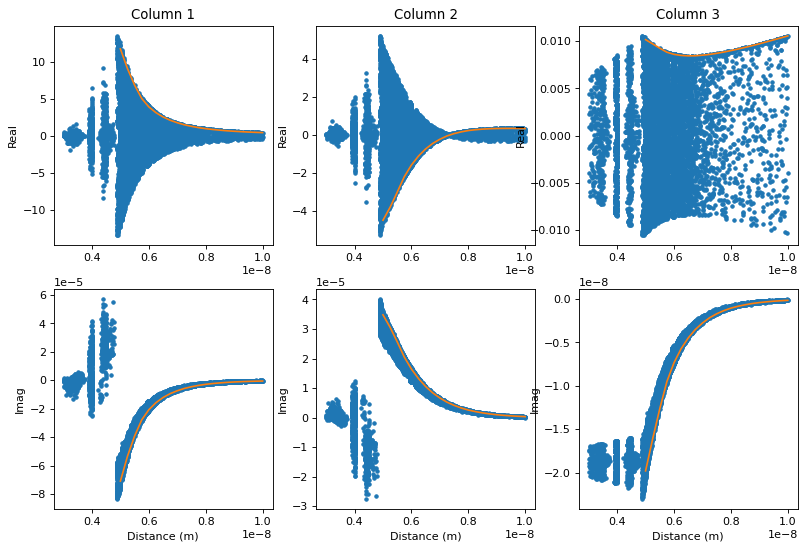

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

ansol=ansol_sphere(output[:,1:5],a=5e-9,rel_perm=78.5,temp_K=298,
                   cinf=100,zval=1,zeta=0.01,gradflag=1)

fig,ax=plt.subplots(2,3,sharey=False,figsize=(12,8),dpi=80)
axs=ax.flatten()

dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)
mask=(dist>3e-9)&(dist<1e-8)
# mask=(dist>.1e-9)&(dist<5e-9)
for i in range(len(unod_list[:3])):
    output=output_unod(nodes,unod_list[i],srvfile)
    
    axs[i].plot(dist[mask],np.real(unod_list[i][mask]),'.')
    #axs[i].plot(output[:,1],ansol[:,0],'*')
    axs[i].plot(output[:,1],output[:,6])
    axs[i].set_title('Column %d'%(i+1))
    axs[i].set_ylabel('Real')
    
    axs[i+3].plot(dist[mask],np.imag(unod_list[i][mask]),'.')
    axs[i+3].plot(output[:,1],output[:,7])
    axs[i+3].set_xlabel('Distance (m)')
    axs[i+3].set_ylabel('Imag')

plt.show()

Computing fields and field gradients in elements
Time elapsed  4.335436582565308 sec

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm



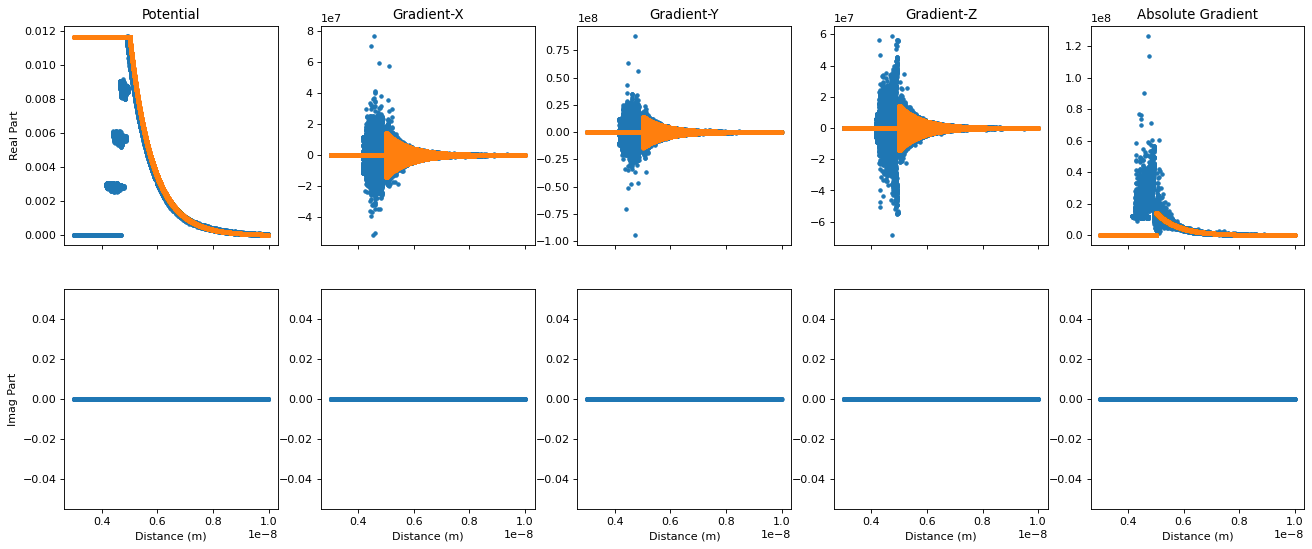

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

midpoints=compute_midpoints3d(nodes,elements)
dist=np.sqrt(midpoints[:,0]**2+midpoints[:,1]**2+midpoints[:,2]**2)
u3d=grad3d(nodes,elements,unod_list[0])
ansol=ansol_sphere(midpoints,a=5e-9,rel_perm=78.5,temp_K=298,
                   cinf=100,zval=1,zeta=0.01,gradflag=1)
u3d=np.append(u3d,np.asmatrix(np.sqrt(u3d[:,1]**2+u3d[:,2]**2+u3d[:,3]**2)).T,axis=1)
ansol=np.append(ansol,np.asmatrix(np.sqrt(ansol[:,1]**2+ansol[:,2]**2+ansol[:,3]**2)).T,axis=1)

fig,ax=plt.subplots(2,5,sharex=True,figsize=(20,8),dpi=80)
axs=ax.flatten()
titles=['Potential','Gradient-X','Gradient-Y','Gradient-Z','Absolute Gradient']

mask=(dist>3e-9)&(dist<1e-8)
# mask=(dist>5e-9)&(dist<1e-8)
for i in range(u3d.shape[1]):
    axs[i].plot(dist[mask],np.real(u3d[mask,i]),'.')
    axs[i].plot(dist[mask],ansol[mask,i],'.')
    axs[i].set_title(titles[i])
    
    axs[i+5].plot(dist[mask],np.imag(u3d[mask,i]),'.')
    axs[i+5].set_xlabel('Distance (m)')
    
axs[0].set_ylabel('Real Part')
axs[5].set_ylabel('Imag Part')
plt.show()